In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
import DataGrabber
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

from utils import set_gpytorch_settings
#gpytorch.settings.max_cholesky_size
set_gpytorch_settings()

# Command in terminal to help with memory allocation
# set PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

In [2]:
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
from custom_kernel import noise_lower, noise_upper, noise_init

In [3]:
# Grab Data and create tensors
data_grab = DataGrabber.DataGrab(site_number='46221', year='9999', data_type=None) # year=["2020", "2021", "2022"])
wave_data = data_grab.process_buoy_data()
#print(data_grab.get_vars())


                time
0       1.349049e+09
1       1.349051e+09
2       1.349053e+09
3       1.349055e+09
4       1.349057e+09
...              ...
175182  1.677801e+09
175183  1.677803e+09
175184  1.677805e+09
175185  1.677807e+09
175186  1.677809e+09

[175187 rows x 1 columns]
                time  wind_dir
0       1.349049e+09     999.0
1       1.349051e+09     999.0
2       1.349053e+09     999.0
3       1.349055e+09     999.0
4       1.349057e+09     999.0
...              ...       ...
175182  1.677801e+09     999.0
175183  1.677803e+09     999.0
175184  1.677805e+09     999.0
175185  1.677807e+09     999.0
175186  1.677809e+09     999.0

[175187 rows x 2 columns]
                time  wind_dir  wind_spd
0       1.349049e+09     999.0      99.0
1       1.349051e+09     999.0      99.0
2       1.349053e+09     999.0      99.0
3       1.349055e+09     999.0      99.0
4       1.349057e+09     999.0      99.0
...              ...       ...       ...
175182  1.677801e+09     999.0     

In [4]:
wave_data = wave_data.replace(to_replace = 999.0, value = np.nan)
wave_data = wave_data.replace(to_replace = 99.0, value = np.nan)
wave_data = wave_data.replace(to_replace = 9999.0, value = np.nan)

wave_data

,time,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
0,1.349049e+09,NaN,NaN,NaN,1.1,17.0,NaN,NaN,NaN,NaN,21.100000,NaN,NaN,NaN
1,1.349051e+09,NaN,NaN,NaN,1.0,17.0,NaN,NaN,NaN,NaN,21.200001,NaN,NaN,NaN
2,1.349053e+09,NaN,NaN,NaN,1.1,17.0,NaN,NaN,NaN,NaN,21.500000,NaN,NaN,NaN
3,1.349055e+09,NaN,NaN,NaN,1.0,17.0,NaN,NaN,NaN,NaN,21.200001,NaN,NaN,NaN
4,1.349057e+09,NaN,NaN,NaN,1.1,18.0,NaN,NaN,NaN,NaN,21.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175182,1.677801e+09,NaN,NaN,NaN,1.2,10.0,NaN,NaN,NaN,NaN,13.700000,NaN,NaN,NaN
175183,1.677803e+09,NaN,NaN,NaN,1.1,18.0,NaN,NaN,NaN,NaN,13.600000,NaN,NaN,NaN
175184,1.677805e+09,NaN,NaN,NaN,1.0,11.0,NaN,NaN,NaN,NaN,13.500000,NaN,NaN,NaN
175185,1.677807e+09,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,13.500000,NaN,NaN,NaN


In [5]:
# for name in wave_data.columns:
#     if name != "time":
#         wave_data.plot(x='time', y=name)

In [6]:
wave_data.drop([49402, 49401, 49403, 49404], axis=0, inplace=True)

In [7]:
wave_data.sort_values('sea_surface_temperature', ascending=False)

,time,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
51378,1.444512e+09,NaN,NaN,NaN,1.1,18.0,NaN,NaN,NaN,NaN,25.200001,NaN,NaN,NaN
51463,1.444681e+09,NaN,NaN,NaN,1.2,20.0,NaN,NaN,NaN,NaN,25.100000,NaN,NaN,NaN
49977,1.441924e+09,NaN,NaN,NaN,1.0,15.0,NaN,NaN,NaN,NaN,25.100000,NaN,NaN,NaN
49978,1.441926e+09,NaN,NaN,NaN,0.8,14.0,NaN,NaN,NaN,NaN,25.000000,NaN,NaN,NaN
49976,1.441922e+09,NaN,NaN,NaN,0.9,14.0,NaN,NaN,NaN,NaN,25.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174828,1.677157e+09,NaN,NaN,NaN,1.3,10.0,NaN,NaN,NaN,NaN,11.800000,NaN,NaN,NaN
174827,1.677155e+09,NaN,NaN,NaN,1.3,8.0,NaN,NaN,NaN,NaN,11.800000,NaN,NaN,NaN
174826,1.677153e+09,NaN,NaN,NaN,1.4,8.0,NaN,NaN,NaN,NaN,11.800000,NaN,NaN,NaN
174834,1.677168e+09,NaN,NaN,NaN,1.2,10.0,NaN,NaN,NaN,NaN,11.800000,NaN,NaN,NaN


In [12]:
wave_data = wave_data.reset_index()


In [13]:
y = torch.tensor(wave_data['sea_surface_temperature'].values.astype(np.float32)).cuda()
X = torch.tensor(wave_data['time'].values.astype(np.float32)).cuda()
X = X.reshape(-1,1)
# wave_data
X
X_old = X

In [14]:
torch.tensor(wave_data['sea_surface_temperature']).mean()

tensor(17.7119)

In [15]:
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

In [16]:

# Standardize Data
#X = (X - X.min(0).values) / (X.max(0).values - X.min(0).values)
X = scaler(X, X_old)
y = y.log()
y = y - torch.min(y)
y = 2 * (y / torch.max(y)) - 1
# Training vs test
from math import floor
#train_n = int(floor(0.9 * len(X)))


In [17]:
#series = wave_data['sea_surface_temperature'].diff().diff(48).dropna().iloc[0:100000]
series = wave_data['sea_surface_temperature']

In [18]:
y

tensor([ 0.5319,  0.5444,  0.5814,  ..., -0.6452, -0.6452, -0.6648])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

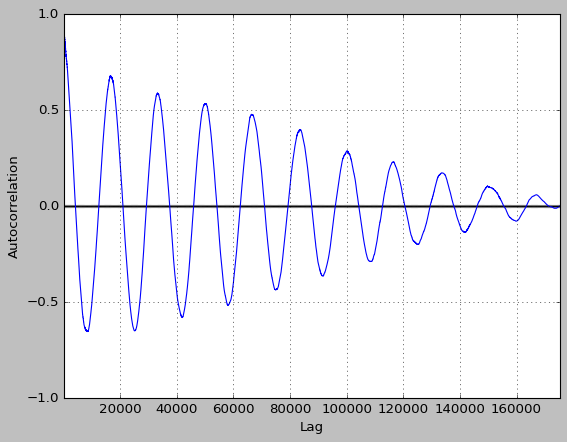

In [19]:
pd.plotting.autocorrelation_plot(series)

In [11]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



#plot_acf(series)
#plot_pacf(series)

#plot_acf(series, lags=1500)
#plot_pacf(series, lags=1500)

In [20]:
test_n = 800
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

In [21]:
print(X.min())
print(X.max())
print(X.mean())

tensor(0.)
tensor(1.)
tensor(0.5015)


In [22]:
print(train_x.min())
print(train_x.max())
print(train_x.mean())

print(test_x.min())
print(test_x.max())
print(test_x.mean())

tensor(0.0044)
tensor(1.)
tensor(0.5038)
tensor(0.9956)
tensor(1.)
tensor(0.9978)


In [23]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [24]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [25]:
from gpytorch.kernels import SpectralMixtureKernel

num_deltas = 300
kernel_old = (
        #ScaleKernel(AR2Kernel()) +
        #ScaleKernel(MinKernel()*RBFKernel()) +
        #ScaleKernel(MinKernel())+
        #ScaleKernel(RBFKernel()) +
        #ScaleKernel(RBFKernel()*LinearKernel())+
        ScaleKernel(MaternKernel(nu=0.5)) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=1e-4,
            upper_bound=0.1,
            initial_value=0.01
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.05,
            upper_bound=0.3,
            initial_value=0.15
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.25,
            upper_bound=1,
            initial_value=0.5
        ))) +
        ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(
            num_dims=train_x.size(-1),
            num_deltas=num_deltas,
        )) +
        ScaleKernel(gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4))
        #ScaleKernel(RBFKernel()*PeriodicKernel())
        )

In [26]:
k4_spectral_base = SpectralMixtureKernel(num_mixtures=4)
k4_spectral_base.initialize_from_data_empspect(train_x, train_y)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
import copy

k1 = copy.deepcopy(k4_spectral_base)

k2 = copy.deepcopy(k4_spectral_base) *PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1/4000,
    upper_bound=5/(2*365),
    initial_value=1/(365*2))
)

k3 = ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1/4000,
    upper_bound=10/(2*365),
    initial_value=1/(2*365))
))

k4 = ScaleKernel(MaternKernel(nu=0.5))

In [ ]:
scaler(60*24, center=False)  # minutes

In [ ]:
scaler(60*24*30, center=False)  # minutes

In [48]:
Mat32 = MaternKernel(nu=1.5)
Mat12 = MaternKernel(nu=0.5)
RBF = RBFKernel()

# Per_Day = PeriodicKernel(
#     period_length_constraint=Interval(
#     lower_bound=scaler(60*24, center=False) / 100,
#     upper_bound=scaler(60*24, center=False) * 100,
#     initial_value=scaler(60*24, center=False))
# )

Per_Month = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=scaler(60*24*30, center=False) / 100,
    upper_bound=scaler(60*24*30, center=False) * 100,
    initial_value=scaler(60*24*30, center=False))
)

Per_Arb = PeriodicKernel()

# kernel = (
# 	k1 + k3 + k4
#     # not: ScaleKernel(k1+k2) since they all have spectral component
# )

kernel = (
	ScaleKernel(Mat12) +
    ScaleKernel(RBF) +
    # ScaleKernel(Per_Day) +
    ScaleKernel(Per_Month)
    # not: ScaleKernel(k1+k2) since they all have spectral component
)


likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(noise_lower, noise_upper,initial_value=noise_init))



In [49]:
#gpytorch.settings.cholesky_max_tries._set_value(100)
gpytorch.settings.cholesky_jitter._set_value(float_value=1e-2, double_value = 1e-2, half_value = 1e-2)

'1.6.0'

In [50]:
num_ind_pts = 800 # Number of inducing points (128 is default for train_and_test_approximate_gp function)
num_epochs = 20

#m1, l1 = utils.train_and_test_approximate_gp(
#    StandardApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m2, l2 = utils.train_and_test_approximate_gp(
#     MeanFieldApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m3, l3 = utils.train_and_test_approximate_gp(
#     MAPApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m4, l4 = utils.train_and_test_approximate_gp(
#     OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m5, l5 = utils.train_and_test_approximate_gp(
#     SpectralDeltaGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
# m6, l6 = utils.train_and_test_approximate_gp(
#     SpectralMixtureGPModel, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
#l1 = gpytorch.likelihoods.GaussianLikelihood()
#m1 = SpectralMixtureGPModel(train_x, train_y, likelihood)
m1, l1 = utils.train_and_test_approximate_gp(
    StandardApproximateGP, kernel, *data_compact, num_epochs=num_epochs, num_ind_pts=num_ind_pts)
#print(kernel.kernels[2].base_kernel.lengthscale)
m2, l2 = utils.train_and_test_approximate_gp(
    OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=num_epochs, num_ind_pts=num_ind_pts)
#print(kernel.kernels[2].base_kernel.lengthscale)


Training StandardApproximateGP:   0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\jrisk\anaconda3\envs\GaussProcesses\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
C:\Users\jrisk\anaconda3\envs\GaussProcesses\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


Test StandardApproximateGP MAE: 0.8160919547080994
--- 231.62766885757446 seconds ---
Test OrthDecoupledApproximateGP MAE: 0.5343183279037476
--- 271.0868685245514 seconds ---


Training OrthDecoupledApproximateGP:   0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
print(m1.covar_module.kernels[0].outputscale)
print(m1.covar_module.kernels[1].outputscale)
print(m1.covar_module.kernels[2].outputscale)


print(m2.covar_module.kernels[0].outputscale)
print(m2.covar_module.kernels[1].outputscale)
print(m2.covar_module.kernels[2].outputscale)



tensor(0.0662, grad_fn=<SoftplusBackward0>)
tensor(0.0647, grad_fn=<SoftplusBackward0>)
tensor(0.0007, grad_fn=<SoftplusBackward0>)
tensor(0.0662, grad_fn=<SoftplusBackward0>)
tensor(0.0647, grad_fn=<SoftplusBackward0>)
tensor(0.0007, grad_fn=<SoftplusBackward0>)


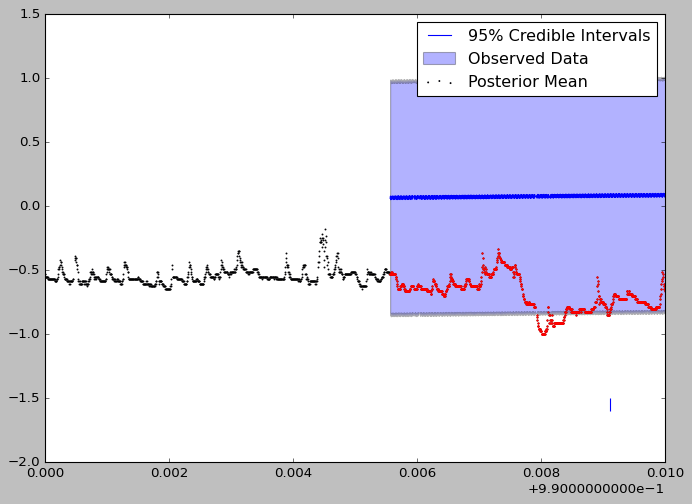

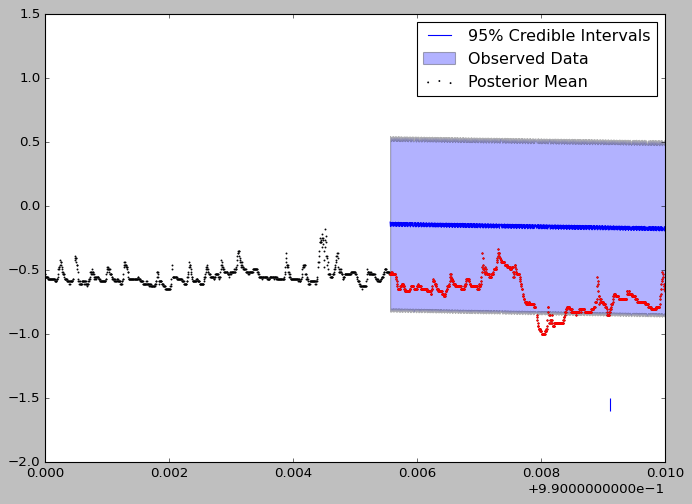

In [53]:
pairs = [[m1, l1],
        [m2, l2],]# [m3, l3],
#         [m4, l4], [m5, l5],
        #[m1, l1]]

for pair in pairs:
    model = pair[0]
    likelihood = pair[1]
    model.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:,0].detach().cpu().numpy(),
                    lower.detach().cpu().numpy(),
                    upper.detach().cpu().numpy(), alpha=0.3)
    # Plot training data as black stars
    ax.scatter(train_x[:,0].detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
    #ax.scatter(model.variational_strategy.inducing_points[:,0].detach().cpu().numpy(),
    #           np.zeros(500)+1, s=0.5)
    # Plot predictive means as blue line
    ax.plot(test_x[:,0].detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')
    ax.scatter(
        test_x[:,0].detach().cpu().numpy(),
        test_y.detach().cpu().numpy(),
        s=1, color="red")
    ax.set_xlim(.99,1)
    #ax.set_xlim(0,1)
    #ax.set_xlim(0.65,0.75)
    ax.vlines(m1.variational_strategy.inducing_points.detach().cpu().numpy(), ymin = -1.6, ymax = -1.5)

    #ax.set_ylim([0, 1.5])
    #ax.patch.set_facecolor('green')
    #ax.patch.set_alpha(.1)
    ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])

In [108]:
test_x.shape

torch.Size([800, 1])

In [109]:
train_x


tensor([[0.0044],
        [0.0045],
        [0.0045],
        ...,
        [1.0000],
        [1.0000],
        [1.0000]])

In [110]:
with torch.no_grad():
    m1(test_x)

In [111]:
# for i in range(len(m1.covar_module.kernels)):
#     print(m1.covar_module.kernels[i].outputscale)
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   32564 KB |  463593 KB |    8693 GB |    8693 GB |\n|       from large pool |   25336 KB |  430288 KB |    8296 GB |    8296 GB |\n|       from small pool |    7227 KB |   35662 KB |     397 GB |     397 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |   32564 KB |  463593 KB |    8693 GB |    8693 GB |\n|       from large pool |   25336 KB |  430288 KB |

In [111]:
from utils import get_BIC

print(get_BIC(m1, likelihood, train_y, train_x))

In [ ]:
m1.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(m1(test_x))


In [ ]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.detach().cpu().numpy(),
                lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), alpha=0.3)
# Plot training data as black stars
ax.scatter(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')

ax.set_ylim([0, 1.5])
#ax.patch.set_facecolor('green')
#ax.patch.set_alpha(.1)
ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])